In [ ]:
# @title Imports Necesarios
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, TargetEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [ ]:
# @title Carga de Datos y reproducibilidad
SEMILLA = 111014

URL_BASE = '/content/drive/MyDrive/MATERIAS/Ciencia de Datos/nlp-getting-started/'

train_file = URL_BASE + 'train.csv'
test_file  = URL_BASE + 'test.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

In [ ]:
# @title Limpieza de datos y creacion de features:

def process_data_ml(df):
    df_out = df.copy()

    df_out['keyword'] = (
        df_out['keyword']
        .fillna('no_keyword')
        .str.replace('%20', ' ', regex=False)
        .str.strip()
        .str.lower()
    )
    df_out['text'] = df_out['text'].fillna('')

    # Feature Engineering (numéricas)
    df_out['word_count'] = df_out['text'].apply(lambda x: len(str(x).strip().split()))
    df_out['special_chars_count'] = df_out['text'].apply(
        lambda x: len(re.findall(r'[^\w\s]', str(x)))
    )

    df_out['has_url'] = df_out['text'].str.contains(r'http[s]?://', regex=True).astype(int)

    # Feature Categórica extra: tipo de "contexto noticioso"
    def news_type(text):
        t = text.lower()
        if t.startswith("rt "):
            return "retweet"
        elif "http" in t:
            return "link"
        elif "news" in t:
            return "news"
        else:
            return "none"

    df_out['news_type'] = df_out['text'].apply(news_type)

    return df_out


# Aplicamos limpieza
df_train_processed = process_data_ml(df_train)
df_test_processed = process_data_ml(df_test)

In [ ]:
# @title Seleccion de features y Split de datos
features = ['text', 'keyword', 'news_type', 'word_count', 'special_chars_count', 'has_url']
target = 'target'

X = df_train_processed[features]
y = df_train_processed[target]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEMILLA,
    stratify=y
)


In [ ]:
# @title Definicion del modelo
numeric_features = ['word_count', 'special_chars_count', 'has_url']
categorical_features = ['keyword', 'news_type']
text_feature = 'text'

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

text_transformer = TfidfVectorizer(stop_words='english', max_features=3000)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('txt', text_transformer, text_feature)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=SEMILLA))
])

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEMILLA)

param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenamos solo con el set de entrenamiento
grid_search.fit(X_train, y_train)

print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor F1 en Cross-Validation (Train): {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits

Mejores parámetros: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Mejor F1 en Cross-Validation (Train): 0.7426


In [ ]:
# @title Metricas de validacion del mejor modelo
best_model = grid_search.best_estimator_

# Predecimos sobre el set que guardamos al principio
y_val_pred = best_model.predict(X_val)


from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Calcular F1 (Métrica principal del TP)
val_f1 = f1_score(y_val, y_val_pred)

print(f"F1 Score: {val_f1:.4f}")

# La accuracy es una metrica que se mide en:
#Cantidad de aciertos / Totales
# Usando 0.5 de umbral
accuracy = accuracy_score(y_val, y_val_pred)

# La precision es una metrica que se mide en:
# Cuantos Desastres predichos son de verdad desastres
# (Cantidad de 1s correctos / Cantidad de 1s) o lo mismo pero con los 0s
precision_1 = precision_score(y_val, y_val_pred, pos_label=1)
precision_0 = precision_score(y_val, y_val_pred, pos_label=0)


# Es el Analogo de la Precision:
# Recall: Cuantos de los que son de una clase predije como de esa clase?
# 1s Recuperados / Cantidad total de 1s
recall_1 = recall_score(y_val, y_val_pred, pos_label=1)
recall_0 = recall_score(y_val, y_val_pred, pos_label=0)

print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision 0: {precision_0:.4f} (No Desastre)")
print(f"Precision 1: {precision_1:.4f} (Desastre)")
print(f"Recall 0:    {recall_0:.4f}    (No Desastre)")
print(f"Recall 1:    {recall_1:.4f}    (Desastre)")

F1 Score: 0.7558
Accuracy:    0.8011
Precision 0: 0.8024 (No Desastre)
Precision 1: 0.7990 (Desastre)
Recall 0:    0.8642    (No Desastre)
Recall 1:    0.7171    (Desastre)


##¿Cuál es el mejor score de validación obtenido?
- El mejor score de validación fue 0.7568

##¿Cómo conviene obtener el dataset para validar?
- El Dataset conviene separarlo 80% en train y 20% en validacion y cuando entremamos solo tenemos que usar los datos de train y no mostrar datos como el target, si no seguramente nos de una metrica muy alta pero lo estamos haciendo mal. Ej dice si tiene el target en 1 predigo 1.




¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

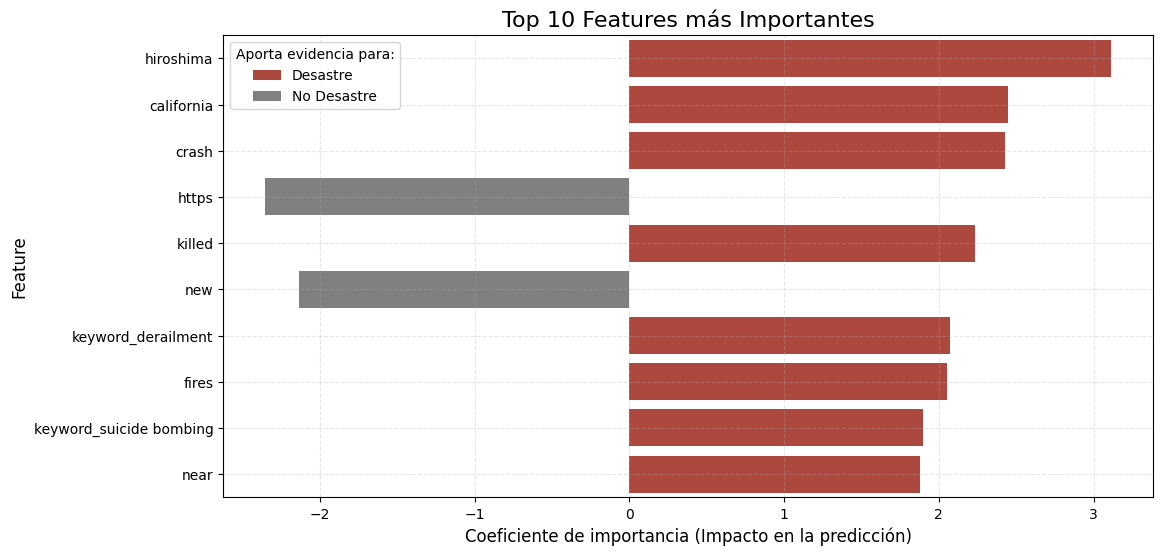

In [ ]:
# Definimos los nombres de las features numéricas (coinciden con las que pasamos al ColumnTransformer)
feature_names_num = ['word_count', 'special_chars_count', 'has_url']

# Extraemos los nombres de las features categóricas del OneHotEncoder
cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
feature_names_cat = cat_encoder.get_feature_names_out(categorical_features)

# Extraemos los nombres de las features de texto
feature_names_text = best_model.named_steps['preprocessor'].named_transformers_['txt'].get_feature_names_out()

# Concatenamos todas las features
all_feature_names = np.r_[feature_names_num, feature_names_cat, feature_names_text]

# Obtenemos los coeficientes del clasificador
coefficients = best_model.named_steps['classifier'].coef_[0]

# Creamos DataFrame de importancia
df_imp = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
df_imp['Abs_Coeff'] = df_imp['Coefficient'].abs()

# Top 10 features
top_10_features = df_imp.sort_values(by='Abs_Coeff', ascending=False).head(10).copy()

top_10_features['Color_Group'] = top_10_features['Coefficient'].apply(
    lambda x: 'Desastre' if x > 0 else 'No Desastre'
)

custom_palette = {'Desastre': '#C0392B', 'No Desastre': '#808080'}

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_10_features,
    x='Coefficient',
    y='Feature',
    hue='Color_Group',
    palette=custom_palette,
)
plt.title('Top 10 Features más Importantes', fontsize=16)
plt.xlabel('Coeficiente de importancia (Impacto en la predicción)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Aporta evidencia para:', loc='upper left')
plt.show()


In [ ]:
# @title Predicciones del BaseLine

test_ids = df_test['id']
y_test_pred = best_model.predict(df_test_processed[features])

submission = pd.DataFrame({
    'id': test_ids,
    'target': y_test_pred
})

submission.to_csv(URL_BASE + 'submission_baseline.csv', index=False)
print(submission.head())

   id  target
0   0       1
1   2       1
2   3       1
3   9       0
4  11       1


## Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido?!
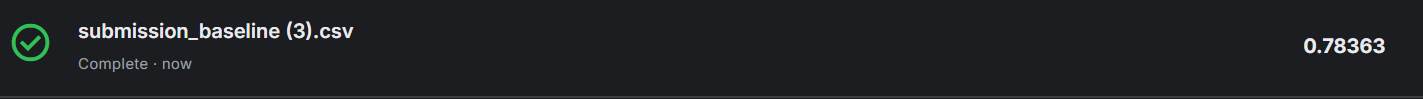

# 0.78363